Starting Experiment: levy (scale=5.0)
Step 0, Loss: 4.3237
Step 100, Loss: 0.9647
Step 200, Loss: 0.9457
Step 300, Loss: 0.9307
Step 400, Loss: 0.9183
Starting Experiment: gaussian (scale=5.0)
Step 0, Loss: 2.2200
Step 100, Loss: 0.9036
Step 200, Loss: 0.8741
Step 300, Loss: 0.8516
Step 400, Loss: 0.6966
Results saved to levy_experiment_results.png


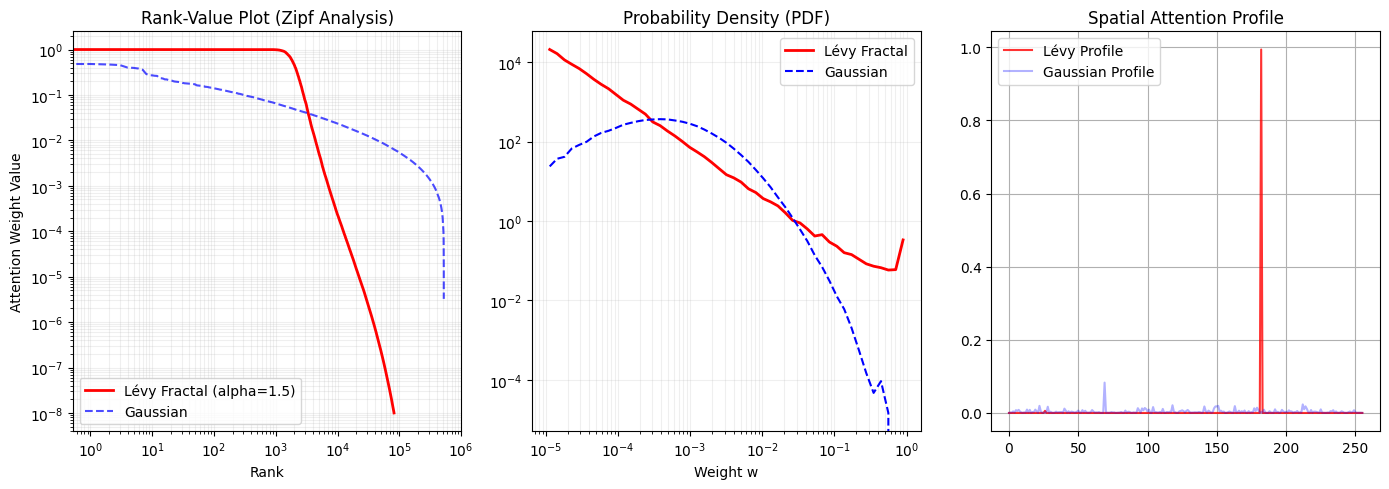

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 数据生成器：升级为 Lévy Flight ---
def generate_levy_flight(seq_len, batch_size, alpha, d_model):
    """
    生成 Lévy Flight 序列。
    alpha: 稳定性参数 (Stability Parameter). 
           alpha=2.0 -> 高斯分布 (退化为布朗运动)
           alpha < 2.0 -> 重尾分布 (Lévy Flight)
           建议 alpha=1.5 左右模拟自然数据
    """
    data = []
    for _ in range(batch_size):
        seq_features = []
        for _ in range(d_model):
            # 生成帕累托分布的步长 (模拟重尾噪声)
            # numpy 的 pareto 是 x^(-alpha-1)
            # 我们生成正负随机的 heavy tail 步长
            step_size = np.random.pareto(alpha, size=seq_len)
            sign = np.random.choice([-1, 1], size=seq_len)
            noise = step_size * sign
            
            # 截断极值防止数值溢出 (模拟物理系统的有限能量)
            noise = np.clip(noise, -50, 50)
            
            # 归一化噪声，但保留其分布形状
            noise = (noise - np.mean(noise)) / (np.std(noise) + 1e-8)
            
            seq_features.append(noise)
        data.append(np.stack(seq_features, axis=1))
    
    return torch.tensor(np.array(data), dtype=torch.float32)

def generate_gaussian_sequence(seq_len, batch_size, d_model):
    return torch.randn(batch_size, seq_len, d_model)

# --- 2. 模型保持不变 ---
class TinyTransformer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads=1, batch_first=True, bias=False)
        self.predictor = nn.Linear(d_model, d_model) 
    
    def forward(self, x):
        attn_output, attn_weights = self.attn(x, x, x)
        prediction = self.predictor(attn_output)
        return prediction, attn_weights

# --- 3. 实验流程 ---
def run_experiment(mode='levy', alpha=1.5, steps=500):
    seq_len = 256 # 增加长度以观察长尾
    d_model = 64  # 增加维度以符合高维假设
    batch_size = 8
    
    model = TinyTransformer(d_model)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # 进一步降低温度：Input Scale
    # 在重尾输入下，这个值不需要太大，因为重尾本身就有大值
    input_scale = 5.0 
    
    print(f"Starting Experiment: {mode} (scale={input_scale})")
    
    loss_history = []
    final_attn = None
    
    for i in range(steps):
        if mode == 'levy':
            # alpha=1.5 是典型的自然界分形指数
            inputs = generate_levy_flight(seq_len, batch_size, alpha, d_model)
        else:
            inputs = generate_gaussian_sequence(seq_len, batch_size, d_model)
            
        target = inputs 
        
        optimizer.zero_grad()
        preds, attn = model(inputs * input_scale)
        loss = criterion(preds, target)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print(f"Step {i}, Loss: {loss.item():.4f}")
            
        final_attn = attn.detach()
        
    return final_attn

# --- 4. 可视化：增加 Rank-Plot ---
def plot_results(attn_fractal, attn_gaussian):
    # 展平并排序 (Rank-Value Plot)
    w_f = np.sort(attn_fractal.flatten().numpy())[::-1] # 降序
    w_g = np.sort(attn_gaussian.flatten().numpy())[::-1]
    
    # 过滤掉极小值
    w_f = w_f[w_f > 1e-8]
    w_g = w_g[w_g > 1e-8]
    
    plt.figure(figsize=(14, 5))
    
    # --- 图1: Rank-Value Plot (Zipf Law Check) ---
    # 这是验证幂律最直观的方法：直线 = 幂律
    plt.subplot(1, 3, 1)
    plt.loglog(w_f, label='Lévy Fractal (alpha=1.5)', color='red', linewidth=2)
    plt.loglog(w_g, label='Gaussian', color='blue', linestyle='--', alpha=0.7)
    plt.title('Rank-Value Plot (Zipf Analysis)')
    plt.xlabel('Rank')
    plt.ylabel('Attention Weight Value')
    plt.legend()
    plt.grid(True, which="both", alpha=0.2)
    
    # --- 图2: PDF (Log-Log Histogram) ---
    plt.subplot(1, 3, 2)
    bins = np.logspace(np.log10(1e-5), np.log10(1.0), 50)
    counts_f, _ = np.histogram(w_f, bins=bins, density=True)
    counts_g, _ = np.histogram(w_g, bins=bins, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    
    plt.loglog(centers, counts_f, label='Lévy Fractal', color='red', linewidth=2)
    plt.loglog(centers, counts_g, label='Gaussian', color='blue', linestyle='--')
    plt.title('Probability Density (PDF)')
    plt.xlabel('Weight w')
    plt.legend()
    plt.grid(True, which="both", alpha=0.2)

    # --- 图3: Attention Profile (Single Sample) ---
    plt.subplot(1, 3, 3)
    sample_idx = 0
    row_idx = 30
    row_f = attn_fractal[sample_idx, row_idx, :].numpy()
    row_g = attn_gaussian[sample_idx, row_idx, :].numpy()
    
    plt.plot(row_f, label='Lévy Profile', color='red', alpha=0.8)
    plt.plot(row_g, label='Gaussian Profile', color='blue', alpha=0.3)
    plt.title('Spatial Attention Profile')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('levy_experiment_results.png')
    print("Results saved to levy_experiment_results.png")

if __name__ == "__main__":
    attn_levy = run_experiment(mode='levy', alpha=1.5) # alpha<2 产生重尾
    attn_gauss = run_experiment(mode='gaussian')
    plot_results(attn_levy, attn_gauss)